In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
from random import randint
from copy import deepcopy
import pickle as pkl
import argparse

from torch import nn
from models import AutoEncoder, AutoEncoderSimple, load_model
import torch.nn.functional as F

from models import load_model
sys.path.append('../../src')
sys.path.append('../../src/vae')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/cosmology')
from dset import get_dataloader
from model import init_specific_model
from losses import get_loss_f, _reconstruction_loss
from training import Trainer
from viz import viz_im_r, cshow, viz_filters
from sim_cosmology import p

sys.path.append('../../lib/trim')
# trim modules
from trim import DecoderEncoder, TrimModel
from captum.attr import *

# wavelet
from pytorch_wavelets import DTCWTForward, DTCWTInverse
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis
from kymatio.torch import Scattering2D
from kymatio.scattering2d.filter_bank import filter_bank
from kymatio.scattering2d.utils import fft2
from colorsys import hls_to_rgb
import pywt

from PIL import Image
import urllib.request
import io


## load data and model

In [2]:
# create dir
out_dir = opj(p.out_dir, p.dirname)
os.makedirs(out_dir, exist_ok=True)  

# seed
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)

# get dataloaders
train_loader = get_dataloader(p.data_path, 
                              img_size=256,
                              batch_size=p.train_batch_size)
im = iter(train_loader).next()[0][0:1]

# load model
model = load_model(model_name='resnet18', device=device, data_path=p.data_path)
model = model.eval()
# freeze layers
for param in model.parameters():
    param.requires_grad = False

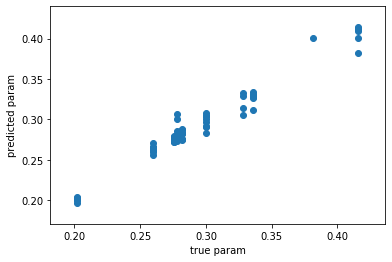

In [3]:
with torch.no_grad():
    im, params = iter(train_loader).next()
    im = im.to(device)
    preds = model(im)[:,1].cpu()
    params = params[:,1]
# print(result)
plt.scatter(params, preds)
plt.xlabel('true param')
plt.ylabel('predicted param')
plt.show()    

## wavelet

In [4]:
class Wavelet_Transform(nn.Module):
    def __init__(self, init_wavelet='bior2.2', requires_grad=True, device='cuda'): 
        super(Wavelet_Transform, self).__init__()        
        # initialize        
        w = pywt.Wavelet(init_wavelet)
        dec_hi = torch.tensor(w.dec_hi[::-1])
        dec_lo = torch.tensor(w.dec_lo[::-1])
        rec_hi = torch.tensor(w.rec_hi)
        rec_lo = torch.tensor(w.rec_lo)        
        self.dec_hi = nn.Parameter(dec_hi.to(device), requires_grad=requires_grad)
        self.dec_lo = nn.Parameter(dec_lo.to(device), requires_grad=requires_grad)
        self.rec_hi = nn.Parameter(rec_hi.to(device), requires_grad=requires_grad)
        self.rec_lo = nn.Parameter(rec_lo.to(device), requires_grad=requires_grad)
        
        self.filters = torch.stack([self.dec_lo.unsqueeze(0)*self.dec_lo.unsqueeze(1),
                                    self.dec_lo.unsqueeze(0)*self.dec_hi.unsqueeze(1),
                                    self.dec_hi.unsqueeze(0)*self.dec_lo.unsqueeze(1),
                                    self.dec_hi.unsqueeze(0)*self.dec_hi.unsqueeze(1)], dim=0)  
        
        self.inv_filters = torch.stack([self.rec_lo.unsqueeze(0)*self.rec_lo.unsqueeze(1),
                                        self.rec_lo.unsqueeze(0)*self.rec_hi.unsqueeze(1),
                                        self.rec_hi.unsqueeze(0)*self.rec_lo.unsqueeze(1),
                                        self.rec_hi.unsqueeze(0)*self.rec_hi.unsqueeze(1)], dim=0)        
    
    def xfm(self, x, levels=5):
        # wavelet transform
        h = x.size(2)
        w = x.size(3)
        x_t = F.conv2d(x, self.filters[:,None], stride=2, padding=2) # only works for filter of size 6
        res = x_t.clone()
        if levels > 1:
            res = self.xfm(res[:,:1], levels=levels-1)
            x_t[:,:1] = res
        x_t = x_t.reshape(-1,2,h//2,w//2).transpose(1,2).contiguous().reshape(-1,1,h,w)
        return x_t
    
    def ifm(self, x, levels=5):
        # inverse wavelet transform
        h = x.size(2)
        w = x.size(3)
        res = x.reshape(-1,h//2,2,w//2).transpose(1,2).contiguous().reshape(-1,4,h//2,w//2).clone()
        if levels > 1:
            res[:,:1] = self.ifm(res[:,:1], levels=levels-1)
        res = F.conv_transpose2d(res, self.inv_filters[:,None], stride=2)
        res = res[:,:,2:-2,2:-2]
        return res
    

class Mask_WaveCoeffs(nn.Module):
    def __init__(self, img_size=256, requires_grad=True, device='cuda'):
        super(Mask_WaveCoeffs, self).__init__()
        self.img_size = img_size
        mask_init = torch.ones(img_size,img_size)
        self.mask = nn.Parameter(mask_init.to(device), requires_grad=requires_grad)
        
    def forward(self, x):
        return torch.mul(x, self.mask)
    
    def projection(self):
        self.mask.data = torch.clamp(self.mask.data, 0, 1)    

In [5]:
# input
torch.manual_seed(p.seed)
im = iter(train_loader).next()[0][0:1].to(device)

# wavelet transform
wt = Wavelet_Transform()
im_w = wt.xfm(im, levels=5)

# prepend transformation onto network
transform_i = lambda x: wt.ifm(x, levels=5)
model_t = TrimModel(model, transform_i, use_residuals=True)

# interp score
attributer = InputXGradient(model_t)
attribution = attributer.attribute(im_w, target=1, additional_forward_args=deepcopy(im))

num_epochs = 1000

num_lamb = 20
lamb_l1 = np.geomspace(0.00001, 0.001, num_lamb)
Losses = []
masks = []

for i, lamb in enumerate(lamb_l1):
    # mask
    mask = Mask_WaveCoeffs(img_size=256)
    # Setup Adam optimizer
    optimizer = torch.optim.Adam(mask.parameters(), lr=0.01)
    
    # Training Loop
    # Lists to keep track of progress
    losses = []
    
    print("\nStarting Training Loop...")
    print("Lambda {}/{}".format(i, len(lamb_l1)))
    # For each epoch
    for epoch in range(num_epochs):
        loss = -mask(attribution).sum() + lamb * mask.mask.sum()
        # zero grad
        optimizer.zero_grad()
        # backward
        loss.backward(retain_graph=True)
        # Update G
        optimizer.step()
        # projection
        mask.projection()

        # Output training stats
        print('\rTrain Epoch: {}/{}'.format(epoch+1, num_epochs), end='')

        # Save Losses for plotting later
        losses.append(loss.item())
    Losses.append(losses)
    masks.append(mask)


Starting Training Loop...
Lambda 0/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 1/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 2/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 3/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 4/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 5/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 6/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 7/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 8/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 9/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 10/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 11/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 12/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 13/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 14/20
Train Epoch: 1000/1000
Starting Training Loop...
Lambda 15/20
Train Epoch: 1000/1000
Starting Training

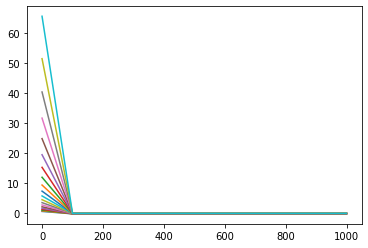

In [6]:
for i in range(num_lamb):
    plt.plot(Losses[i])
plt.show()

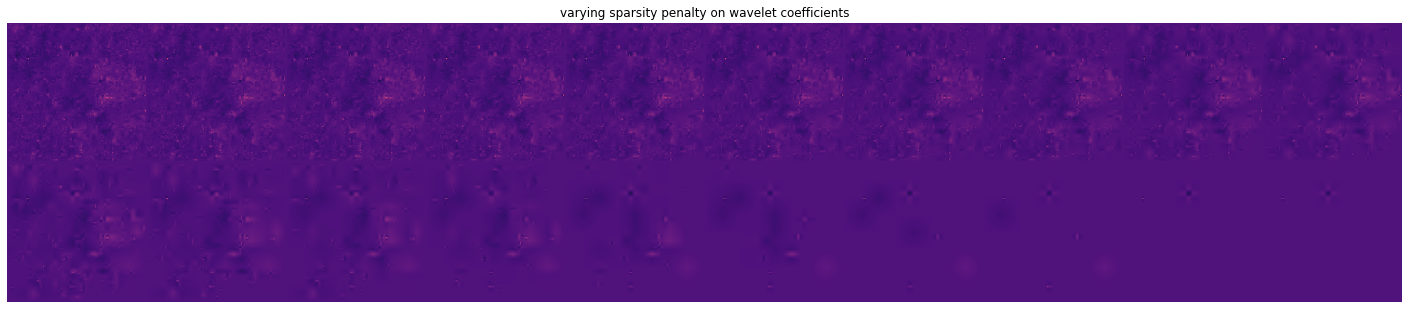

In [7]:
# viz
plt.figure(figsize=(25,25))
vmax=0.15
vmin=-0.05
n_row = 2
n_col = 10
p = 256 + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        im_ = wt.ifm(masks[indx](wt.xfm(im))).squeeze().data.cpu().numpy()
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(im_,(1,1),mode='constant')
        indx += 1
plt.title("varying sparsity penalty on wavelet coefficients")
plt.imshow(mosaic, cmap='magma', vmax=vmax, vmin=vmin)
plt.axis('off')    
plt.show()         
        

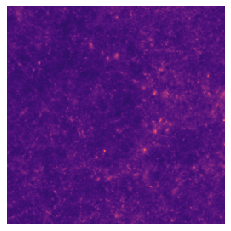

In [8]:
cshow(im.data.cpu().squeeze())

## sort in decreasing order

In [201]:
# input
torch.manual_seed(35)
im = iter(train_loader).next()[0][0:1].to(device)

# wavelet transform
wt = Wavelet_Transform()
im_w = wt.xfm(im, levels=5)

# prepend transformation onto network
transform_i = lambda x: wt.ifm(x, levels=5)
model_t = TrimModel(model, transform_i, use_residuals=True)

# interp score
attributer = InputXGradient(model_t)
attribution = attributer.attribute(im_w, target=1, additional_forward_args=deepcopy(im))

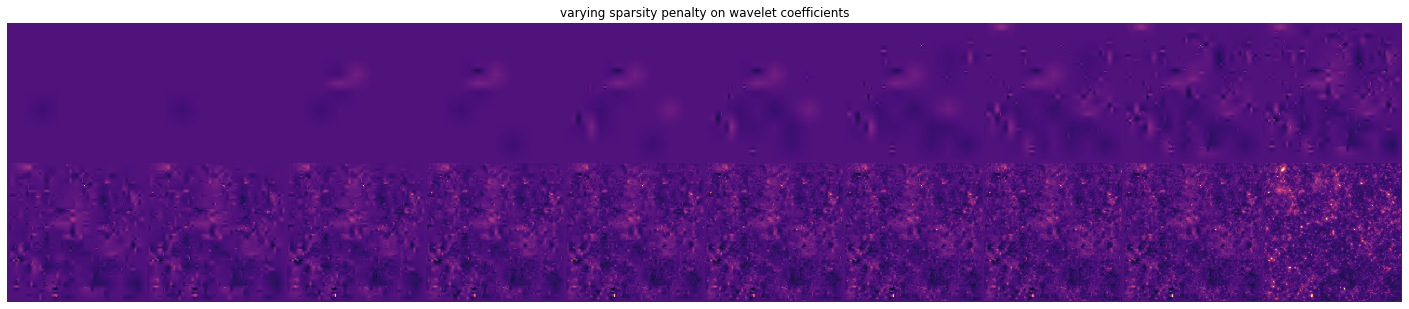

In [202]:
# sparsity level
num_sp = 20
sp_level = np.geomspace(1, 256*256, num_sp).astype(np.int)

# viz
plt.figure(figsize=(25,25))
vmax=0.15
vmin=-0.05
n_row = 2
n_col = 10
p = 256 + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        a = attribution.cpu()
        b = a.reshape(-1).clone()
        sort_order = torch.argsort(b, descending=True) 
        m = torch.zeros_like(b)
        m[sort_order[:sp_level[indx]]] = 1
        m = m.reshape(1,1,256,256)
        im_ = transform_i(torch.mul(im_w, m.to(device))).squeeze().data.cpu().numpy()
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(im_,(1,1),mode='constant')
        indx += 1
plt.title("varying sparsity penalty on wavelet coefficients")
plt.imshow(mosaic, cmap='magma', vmax=vmax, vmin=vmin)
plt.axis('off')    
plt.show()         
        

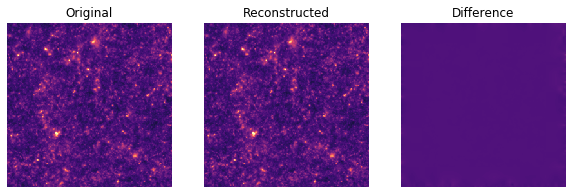

In [198]:
res = wt.xfm(im, levels=5)
rec = wt.ifm(res, levels=5)
viz_im_r(im[0,0], rec[0,0])

In [10]:
torch.norm(im[0,0] - rec[0,0])

tensor(0.1426, device='cuda:0', grad_fn=<NormBackward0>)